In [1]:
import torch
import gym
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

In [2]:
env = gym.make("Roulette-v0")
state = env.reset()
print(state)

0


In [3]:
num_states = env.observation_space.n
num_actions = env.action_space.n
print(num_states, num_actions)

1 38


In [4]:
env.step(1)

(0, 1.0, False, {})

## Off-policy Monte Carlo
Why does this not work?

In [5]:
# Roulette has only one state: 0. It is not actually needed to keep track of that

def run_episode(env, behaviour_policy):
    # Exploring starts run
    state = env.reset()
    memo, is_done = [], False
    while not is_done:
        probs = behaviour_policy(state)
        action = torch.multinomial(probs, 1).item()
        new_state, reward, is_done, info = env.step(action)
        memo.append((state, action, reward))
        state = new_state
    return memo

In [6]:
def generate_random_policy(num_actions):
    probs = torch.ones(num_actions) / num_actions
    def policy_function(state):
        return probs
    return policy_function

In [7]:
behaviour_policy = generate_random_policy(num_actions)
memory = run_episode(env, behaviour_policy)
# pprint(memory)

In [8]:
total_reward = 0
for _, __, reward in memory:
    total_reward += reward 
print(total_reward)

-1.0


In [9]:
# Is not working because early stopping isn't considered viable

def off_policy_mc_control(env, gamma, num_episodes, behaviour_policy):
    num_actions = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.zeros(num_actions))

    for episode in tqdm(range(num_episodes)):
        weights = {}
        w = 1
        memory = run_episode(env, behaviour_policy)
        return_proba = 0    
        G = {}
        for state, action, reward in reversed(memory):
            return_proba = gamma * return_proba + reward
            G[(state, action)] = return_proba
            w = w / float(behaviour_policy(state)[action])
            weights[(state, action)] = w
            if action != torch.argmax(Q[state]):                     # Only continue as long as behaviour and target policies match
                break
           
        for state_action, return_proba in G.items():
            state, action = state_action
            G_sum[state_action] += return_proba * weights[state_action]
            N[state_action] += 1
            Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

In [27]:
gamma = 1
episode_list = [5000, 50000, 500000]
random_policy = generate_random_policy(env.action_space.n)

off_policy_dict = {}
for num_episodes in episode_list:
    optimal_Q, optimal_policy = off_policy_mc_control(env, gamma, num_episodes, random_policy)
    off_policy_dict[num_episodes] = [optimal_Q, optimal_policy]
    print("\n", optimal_policy)

  0%|          | 14/50000 [00:00<06:11, 134.56it/s]
 {0: 0}
  0%|          | 13/500000 [00:00<1:07:46, 122.94it/s]
 {0: 20}
100%|██████████| 500000/500000 [1:03:37<00:00, 130.98it/s]
 {0: 17}



In [32]:
optimal_Q, optimal_policy = off_policy_mc_control(env, gamma, 5000, random_policy)
print(optimal_policy)

100%|██████████| 5000/5000 [00:14<00:00, 336.05it/s]{0: 1}



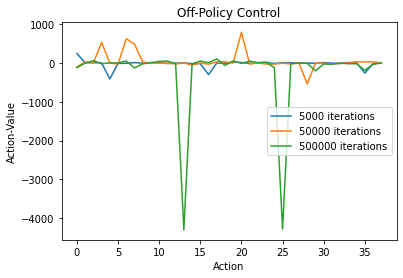

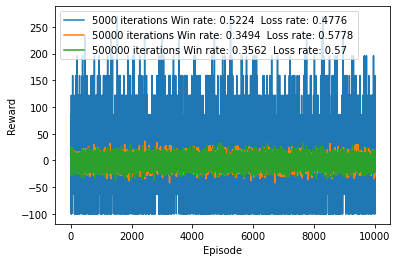

In [31]:
plot_roulette(off_policy_dict, "off-policy control", num_episodes=10000)

## On-policy Control
Huzzah! It works!

In [10]:
def run_eps_episode(env, Q, epsilon, num_actions):
    state = env.reset()
    memo = []
    is_done = False
    while not is_done:
        proba = torch.ones(num_actions) * epsilon / num_actions    
        # epsilon-greedy starting probabilities
        best_action = torch.argmax(Q[state]).item()
        proba[best_action] += 1 - epsilon
        action = torch.multinomial(proba, 1).item()                  
        # Choose 1 action from the multinomial distribution
        new_state, reward, is_done, info = env.step(action)
        memo.append((state, action, reward))
        state = new_state
    return memo

In [11]:
def on_policy_mc_control(env, gamma, epsilon, num_episodes):
    num_actions = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.zeros(num_actions))  #(1x38 in this case)
    for episode in tqdm(range(num_episodes)):
        memory = run_eps_episode(env, Q, epsilon, num_actions)
        return_proba = 0
        G = {}
        for state, action, reward in reversed(memory):
            return_proba = gamma * return_proba + reward
            G[(state, action)] = return_proba
        for state_action, return_proba in G.items():
            G_sum[(state, action)] += return_proba
            N[(state, action)] += 1
            Q[state][action] = G_sum[(state, action)] / N[(state, action)]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy


In [12]:
gamma = 1
epsilon = 0.1
episode_list = [5000, 50000, 500000]

on_policy_dict = {}
for num_episodes in episode_list:
    optimal_Q, optimal_policy = on_policy_mc_control(env, gamma, epsilon, num_episodes)
    on_policy_dict[num_episodes] = [optimal_Q, optimal_policy]
    print("\n", optimal_policy)


  0%|          | 6/50000 [00:00<14:26, 57.69it/s]
 {0: 37}
  0%|          | 5/500000 [00:00<3:21:38, 41.33it/s]
 {0: 37}
100%|██████████| 500000/500000 [02:10<00:00, 3844.22it/s]
 {0: 37}



In [30]:
def run_test(policy, iters, num_episodes):
    env = gym.make("Roulette-v0")
    rewards = np.zeros(num_episodes)
    wins = 0
    losses = 0
    for i in range(num_episodes):
        state = env.reset()
        is_done = False
        total_reward = 0
        while not is_done:
            action = policy[state]
            state, reward, is_done, _ = env.step(action)
            total_reward += reward
        rewards[i] = total_reward
        if total_reward >= 1:
            wins += 1
        elif total_reward <= -1:
            losses += 1
    label= f"{iters} iterations Win rate: {wins/num_episodes}  Loss rate: {losses/num_episodes}"
    return rewards, label


def plot_roulette(result_dict, title, num_episodes = 1000):
    for k, v in result_dict.items():
        optimal_Q, optimal_policy = v
        plt.plot(np.arange(len(optimal_Q[0])), optimal_Q[0].numpy(), label=f"{k} iterations")
    plt.xlabel("Action")
    plt.ylabel("Action-Value")
    plt.legend()
    plt.title(str.title(title))
    plt.show()
    for k, v in result_dict.items():
        optimal_Q, optimal_policy = v
        rewards, label = run_test(optimal_policy, k, num_episodes)
        plt.plot(rewards, label=label)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()

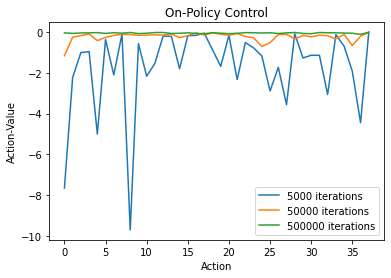

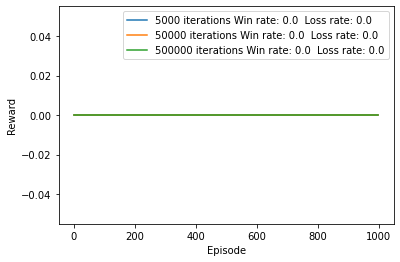

In [26]:
plot_roulette(on_policy_dict, "on-policy control")

In [24]:
pprint(optimal_Q)

defaultdict(<function off_policy_mc_control.<locals>.<lambda> at 0x000002A53E89F8B0>,
            {0: tensor([ -38.0000,   14.2500,   -8.7692,   16.2857,    7.6000,  250.1667,
          10.3636,  -38.0000,    0.0000,    7.6000,    8.7692,   -5.4286,
          16.2857,    6.3333,  346.7500,    4.4706,   -3.8000,   16.2857,
          -6.7059,    0.0000,   -5.4286,    0.0000, -277.4000, -277.4000,
         219.2308,    7.6000,  -14.6154,    2.9231,    0.0000,   10.8571,
           9.5000,   21.1111,  -16.2857,  -19.0000,    0.0000,   17.2727,
         -14.2500,    0.0000])})


In [25]:
pprint(optimal_policy)

{0: 14}
